In [1]:
using GaussianProcesses, Distributions, Plots, LinearAlgebra, Random
Random.seed!(123)
pyplot()

Plots.PyPlotBackend()

linspace (generic function with 1 method)

In [3]:
function linspace(a::Real, b::Real, n::Int64)
    a = range(a, stop =b, length = n) |> collect
end

function k(x::Float64, y::Float64; ℓ=0.5, σ=0.5)
    return σ^2*exp(-0.5 * (x - y)^2/ℓ^2)
end

function build_cov(X::AbstractArray, Y::AbstractArray, k::Function)
    Kff = Array{Float64}(undef, length(X), length(Y))
    for (xidx, x) in enumerate(X)
        for (yidx, y) in enumerate(Y)
            Kff[xidx, yidx] = k(x, y)
        end
    end
    return Kff + Diagonal(repeat([1e-10], length(X)))
end

function zero_mean(x::AbstractArray)
    return zeros(length(x))
end

function sim_gp(n::Int, k::Function; lims::Tuple=(-5., 5.), meanf::Function=zero_mean)
    x = linspace(lims[1], lims[2], n)
    K = build_cov(x, x, k)
    return x, rand(MultivariateNormal(zero_mean(x), K), 1)
end

sim_gp (generic function with 1 method)

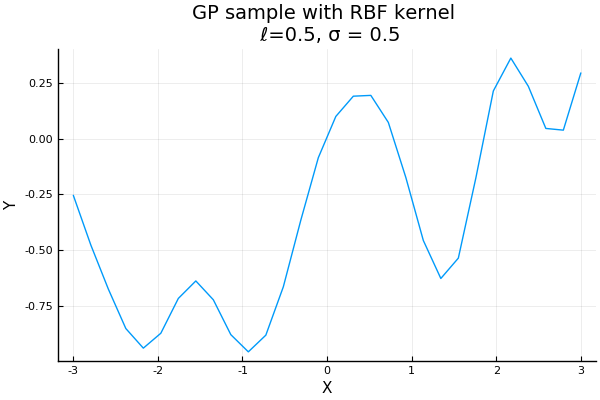

In [67]:
nobs = 30
x, y = sim_gp(nobs, k; lims=(-3, 3))
plot(x, y, leg=false)
title!("GP sample with RBF kernel \n ℓ=0.5, σ = 0.5")
xaxis!("X")
yaxis!("Y")

In [76]:
kern = SE(0.0, 0.0)
meanf = MeanZero()
lik = GaussLik(0.1)
gp = GP(x, reshape(y, size(y, 1)), meanf, kern)
set_priors!(kern, [Normal(0,1), Normal(0,1)])

2-element Array{Normal{Float64},1}:
 Normal{Float64}(μ=0.0, σ=1.0)
 Normal{Float64}(μ=0.0, σ=1.0)

In [77]:
xt = -3:0.1:3
μ, Σ = predict_y(gp, xt);

In [78]:
optimize!(gp)
particles = svgd(gp; nIter=2000, nParticles=20);

100.0%┣████████████████████████████████████████████████████████┫ 2000/2000 [00:06<00:00, 325.4 it/s]


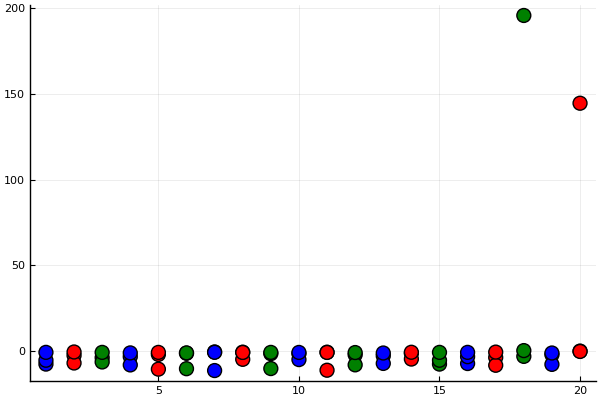

In [81]:
scatter(particles', label="", color=["blue", "red", "green"], markersize=10)

In [82]:
chain = mcmc(gp, nIter=10000, burn=1000, thin=5);

100.0%┣██████████████████████████████████████████████████████┫ 10000/10000 [00:13<00:00, 766.4 it/s]
Number of iterations = 10000, Thinning = 5, Burn-in = 1000 
Step size = 0.100000, Average number of leapfrog steps = 10.019300 
Number of function calls: 100194
Acceptance rate: 0.001200 


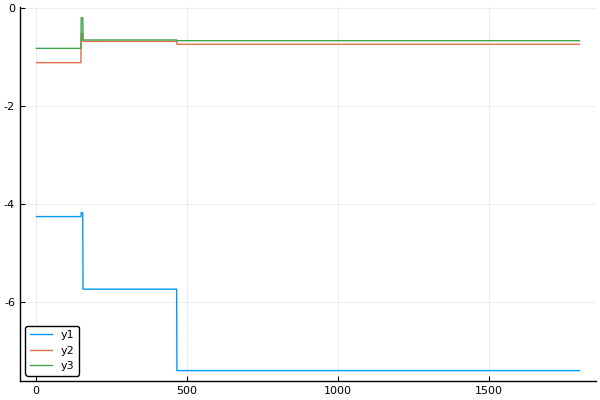

In [83]:
plot(chain')